# GDA

In [1]:
import numpy as np
from autograd import grad
import autograd.numpy as np1
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import time
from scipy.optimize import BFGS,SR1
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

/home/codespace/.local/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/home/codespace/.local/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Optimal solution x: [0.89186294 1.79666735]
Optimal value f*: 0.40936099489314676
GDA:  8.318296194076538
Optimal solution x: [0.89189975 1.79668814]
Optimal value f*: 0.4093634512727765
GDA:  6.4355268478393555
Optimal solution x: [0.89240715 1.79549041]
Optimal value f*: 0.4093698617942619
GDA:  7.021572113037109


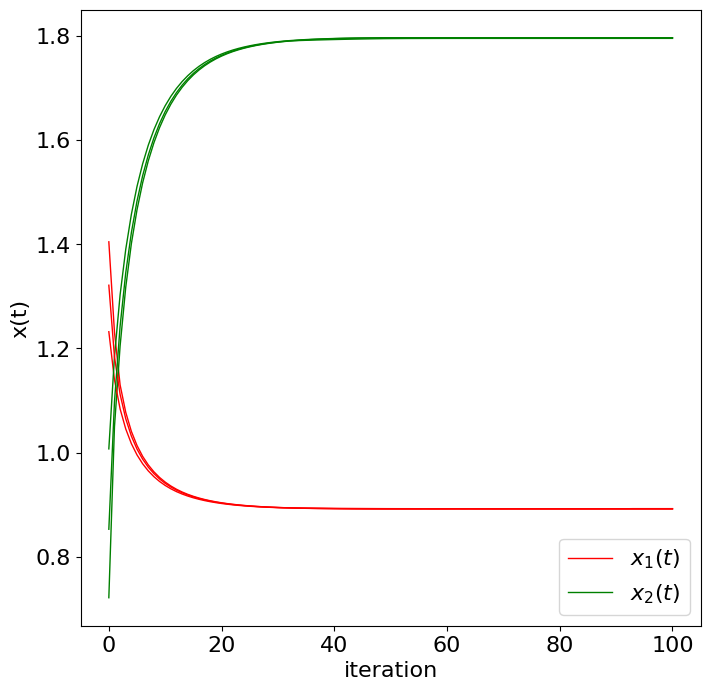

In [ ]:

# Define functions
def ode_solve_G(z0, G, epsi_t, mut, n):
    """
    Simplest RK4 ODE initial value solver
    """
    n_steps = 500
    z = z0
    h = np.array([0.01])
    for i_step in range(n_steps):
        k1 = h * G(z, epsi_t, mut, n)
        k2 = h * (G((z + h/2), epsi_t, mut, n))
        k3 = h * (G((z + h/2), epsi_t, mut, n))
        k4 = h * (G((z + h), epsi_t, mut, n))
        k = (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        z = z + k
    return z

def f(x):
    return (x[0]**2 + x[1]**2 + 3) / (1 + 2*x[0] + 8*x[1])

def g1(x):
    return -x[0]**2 - 2*x[0]*x[1] + 4

def g2(x):
    return -x[0]

def g3(x):
    return -x[1]

g1_dx = grad(g1)
g2_dx = grad(g2)
g3_dx = grad(g3)
g_dx = [g1_dx, g2_dx]
f_dx = grad(f)
bounds = Bounds([0, 0], [np.inf, np.inf])
cons = (
        {'type': 'ineq',
         'fun': lambda x: np.array([-g1(x)]),
         'jac': lambda x: np.array([-g1_dx(x)])})

def rosen(x, y):
    """The Rosenbrock function"""
    return np.sqrt(np.sum((x - y)**2))

def find_min(y, n):
    x = np.random.rand(1, n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point", hess=BFGS(),
                   constraints=cons, method='trust-constr', options={'disp': False}, bounds=bounds)
    return res.x

def run_nonsmooth1(x, max_iters, f, f_dx, n, alpha, mu0):
    res = []
    val = []
    lda = 1  # Fixed step size
    sigma = 0.1
    mut = mu0
    K = np.random.rand(1, 1)
    res.append(x)
    val.append(f(x))
    x_pre = x
    for t in range(max_iters):
        y = x - lda * f_dx(x)
        x_pre = x.copy()
        x = find_min(y, n)
        if f(x) - f(x_pre) + sigma * (np.dot(f_dx(x_pre).T, x_pre - x)) <= 0:
            lda = lda
        else:
            lda = K * lda
        res.append(x)
        val.append(f(x))
    
    # Print the optimal solution and optimal value
    optimal_x = res[-1]
    optimal_f = val[-1]
    print(f"Optimal solution x: {optimal_x}")
    print(f"Optimal value f*: {optimal_f}")
    return res, val

def plot_x(sol_all, count, max_iters):
    t = [i for i in range(max_iters + 1)]
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 16})
    for i in range(count):
        plt.plot(t, sol_all[i][:, 0], color='red', label=r'$x_{1}(t)$', linewidth=1)
        plt.plot(t, sol_all[i][:, 1], color='green', label=r'$x_{2}(t)$', linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{1}(t)$', r'$x_{2}(t)$'])
    plt.show()

if __name__ == '__main__':
    num = 3  # number of init points
    max_iters = 100  # number of iterations
    max_iters1 = 100
    sol_all, sol_all1 = [], []
    val_all, val_all1 = [], []
    count = 0
    epsilon = 0.1
    mu0 = np.random.rand(1)  # init mu0 
    epsi0 = np.random.rand(1)  # init epsi0
    alpha = np.random.rand(1)  # init alpha
    n = 2  # dimension x
    x_init = np.random.rand(1, n)
    for i in range(num):
        x0 = np.random.rand(1, n)
        x0 = find_min(x0, n)  # init point
        count += 1

        t2 = time.time()
        res1, val1 = run_nonsmooth1(x0, max_iters1, f, f_dx, n, alpha, mu0)
        e2 = time.time()
        print("GDA: ", e2 - t2)
        tmp1 = np.array(res1)[:, :]
        sol_all1.append(tmp1)
        val_all1.append(val1)

    # Plot trajectory
    plot_x(sol_all1, count, max_iters)